# 全卷积神经网络 - Fully Convolutional Network (FCN)

In [1]:
import sys
# 将当前目录添加到path
sys.path.append('/home/huqian/data/py_code/')
sys.path

['/home/huqian',
 '/home/huqian/anaconda3/lib/python38.zip',
 '/home/huqian/anaconda3/lib/python3.8',
 '/home/huqian/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/home/huqian/anaconda3/lib/python3.8/site-packages',
 '/home/huqian/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/home/huqian/.ipython',
 '/home/huqian/data/py_code/']

In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from utils.ProgressBar import ProgressBar
from utils.ArrayPainter import convertArr2IMG
from utils.LossTracer import LossTracer
import torch.nn.functional as F

import PIL

### 1. 加载数据集

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = transforms.Compose([
#     transforms.Resize((500,500)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
t_transform = transforms.Compose([
#     transforms.Resize((500,500)),
    transforms.ToTensor()
])

root = '/home/huqian/data/datasets'
train_set = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='train', download=True, transform=transform,target_transform=t_transform)
test_set = torchvision.datasets.VOCSegmentation(root, year='2012', image_set='val', download=True, transform=transform,target_transform=t_transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True,num_workers=4)

Using downloaded and verified file: /home/huqian/data/datasets/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /home/huqian/data/datasets/VOCtrainval_11-May-2012.tar


In [60]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

### 2. 加载优化器和损失函数

In [61]:
LR= 10e-4
EPOCH = 20

lambda2 = lambda epoch: LR* (0.9 ** epoch)

model = torchvision.models.segmentation.fcn_resnet50(pretrained=True, progress=True, num_classes=21)
optim = torch.optim.SGD(model.parameters(),lr = LR,momentum=0.9,weight_decay=5e-4) # 
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda2)
# loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.CrossEntropyLoss()
res = model.to(device)

tracer = LossTracer()

### 3. 训练

In [62]:
def cross_entropy2d(input, target, weight=None, size_average=True):
#     print('input : ', input.size())
#     print('target : ', target.size())
#     print('input : ', input.dtype)
#     print('target : ', target.dtype)
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    log_p = F.log_softmax(input, dim=1)
    
    # log_p: (n*h*w, c)
#     log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
#     log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
#     log_p = log_p.view(-1, c)
    # target: (n*h*w,)
#     mask = target >= 0
#     target = target[mask]
    loss = F.nll_loss(log_p, target[0], weight=weight, reduction='sum')
#     if size_average:
#         loss /= mask.data.sum()
    return loss

In [59]:
model_name = 'fcn'
model_file = model_name+'.pkl'
if os.path.exists(model_file):
    sd = torch.load(model_file)
    model.load_state_dict(sd)


# tracer.load('fcn.json')
  

# tracer = LossTracer()
running_loss = 0
for epoch in range(10):
    progress = ProgressBar(len(train_loader))
    for step, (img, target) in enumerate(train_loader):
        img = img.to(device)
        img = torch.ceil(img*255)
        target = target.to(device,dtype=torch.long)
        
#         print(img[img>0])
#         plt.subplot(1,2,1)
#         x = np.transpose(img.clone().cpu().detach().numpy(),[1,2,0])
#         plt.imshow(np.transpose(img.clone().cpu().detach().numpy(),[1,2,0]))
#         plt.subplot(1,2,2)
#         plt.imshow(np.transpose(img.clone().cpu().detach().numpy(),[1,2,0]))
#         image.save('pic_gt.jpg')
#         image=convertArr2IMG(target[0][0])
#         image.save('pic_gt.jpg')
        
        optim.zero_grad()
        d = model(img)['out']
        loss = cross_entropy2d(d,target)
        loss.backward()
        optim.step()
        running_loss += loss.item()
        
        progress.step(step+1)
#         break
        
#     scheduler.step()
    avg_loss = running_loss/len(train_loader)
    running_loss = 0
    print('EPOCH - ',tracer.epoch_base + epoch +1,'  loss is: ',avg_loss)
    tracer.append(tracer.epoch_base + epoch +1, avg_loss)
    
tracer.epoch_base += EPOCH
tracer.store('fcn.json')

torch.save(model.state_dict(),model_file)

100% |####################################################################################################|Doneing

EPOCH -  1   loss is:  33903.36005505838
100% |####################################################################################################|Doneing

EPOCH -  2   loss is:  34599.13529142786
 62% |##############################################################--------------------------------------|Running

KeyboardInterrupt: 

In [ ]:
!pwd

### 4. 训练损失度展示

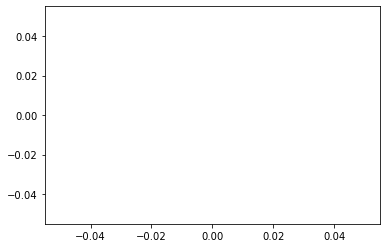

In [63]:
dx = tracer.fetch()
plt.plot(dx[0],dx[1])

In [64]:
for step, (img, target) in enumerate(train_loader):
    img = img.to(device)
    target = target.to(device)
    print(img.size())
    print(target.size())
    pred = model(img)
    print(pred['out'].size())
    break

torch.Size([1, 3, 375, 500])
torch.Size([1, 1, 375, 500])
torch.Size([1, 21, 375, 500])


### 5.原图和Ground-Truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


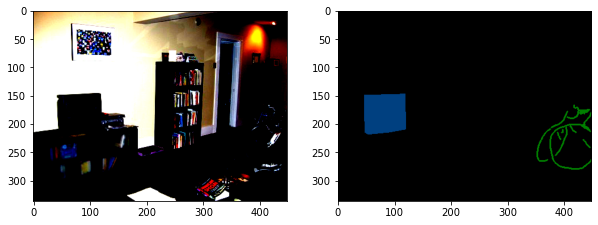

In [78]:
for step, (img, target) in enumerate(train_loader):
    img = img.to(device)
    target = target.to(device,dtype=torch.float)
    
    # predict
    pred = model(img)

    # raw pic
    data = img[0].cpu().numpy()
    data = np.transpose(data,(1,2,0))
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1)
    plt.imshow(data)

    # ground-truth
    data = target[0].cpu().numpy()[0]*255
    data[data==255]=0
    data = data.astype(np.int)
    mask = decode_segmap(data)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    
    # save ground-truth num pic
#     image = convertArr2IMG(data)
#     image.save('pig_raw.jpg')
    break

### 6. 各个通道的信号

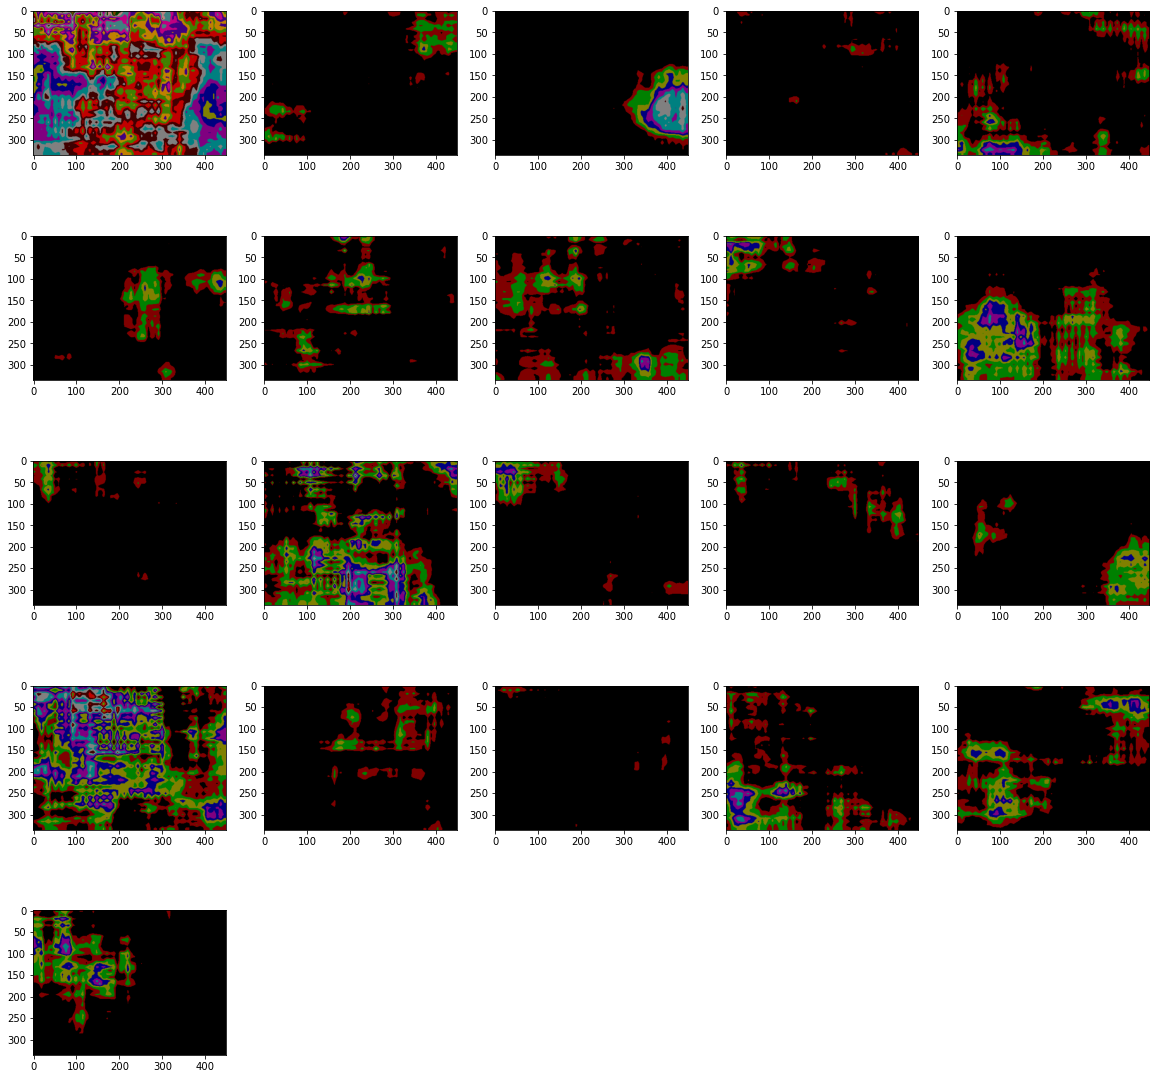

In [79]:
import torch.nn.functional as F
out = pred['out'][0]
data = out.clone().detach().cpu().numpy()

# out = F.softmax(out,dim=0)
# val,idx = torch.max(out,dim=0)

# data = torch.unsqueeze(idx,dim=0).detach().cpu().numpy()


plt.figure(figsize=(20,20))
for idx,d in enumerate(data):
    d = d.astype(np.int)
    name = 'pig_'+str(idx)+'.jpg'
#     image_d = convertArr2IMG(d)
#     image_d.save(name)
    mask = decode_segmap(d)
    plt.subplot(5,5,idx+1)
    plt.imshow(mask)

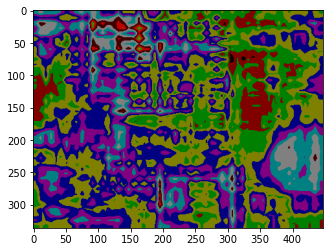

In [80]:
res = np.max(data[1:-1],axis=0)
res = res.astype(np.int)
maskr = decode_segmap(res)
plt.imshow(maskr)
# data.shape

### 7. 计算精度